In [1]:
!pip install python-pdfbox
!pip install pyLDAvis
!pip install skillNer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 16.3 MB/s eta 0:00:00
  Created wheel for python-pdfbox: filename=python_pdfbox-0.1.8.1-py3-none-any.whl size=6181 sha256=e856e2ce4f2f830a711b968c1113203e7b589a8b823d27dd01ff8ce7574b9df5
  Stored in directory: /root/.cache/pip/wheels/43/ae/ed/9a8acbfb2ee61070102a840e01755d0ef38940f1ef4cbe45e4
Successfully built python-pdfbox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for skillNer: filename=skillNer-1.0.3-py3-none-any.whl size=25625 sha256=54bde08c49947d0d9c3bca64a1c3a1f254acf1f62e55cbceae40c5a6bc2d5805
  Stored in directory: /root/.cache/pip/wheels/9a/f1/7a/3201e01141cdb862654585eb16412785ed9973459639c351e4
Successfully built skillNer


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import csv
import os
import glob
import re
import nltk
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc
import re
import gensim
from gensim import corpora
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from pdfbox import PDFBox
import hashlib # file ids
import spacy.cli
spacy.cli.download("en_core_web_lg")
#warning
import warnings
warnings.filterwarnings('ignore')

nltk.download(['stopwords','wordnet'])

nltk.download('omw-1.4')
nlp=spacy.load('en_core_web_lg')



✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
def extract_pdf_text(folder_path):
    text_list = []

    for file in glob.glob(os.path.join(folder_path, "*.pdf")):
        file_name = os.path.basename(file)
        pdf = PDFBox()
        text = pdf.extract_text(file)
        if text:
            text_list.append({"file_name": file_name, "text": text})
        else:
            with open(f"{file_name}.txt", "w") as f:
                f.write("")

In [5]:
def text_to_csv(folder_path):
    csv_file = open('text_files.csv', 'w', newline='')
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'filename', 'text'])

    def generate_id(filename):
        return int(hashlib.md5(filename.encode('utf-8')).hexdigest(), 16)% 100000 #to limit the unique ID to less or equal to 5 digits

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                text = file.read()
                id = generate_id(filename)
                writer.writerow([id, filename, text])

    csv_file.close()

In [6]:
def load_csv(file_path):
        df = pd.read_csv(file_path)
        return df

In [7]:
from spacy.matcher import PhraseMatcher

# load default skills data base
from skillNer.general_params import SKILL_DB
# import skill extractor
from skillNer.skill_extractor_class import SkillExtractor
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)


loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [8]:
def extract_skills(text):

    annotations = skill_extractor.annotate(text)
    doc_node_values = set([x['doc_node_value'] for x in annotations['results']['full_matches']])
    return ', '.join(doc_node_values)


In [9]:
def create_wordcloud(df, column_name):
    skill_cloud = ""
    for i in df[column_name].values:
        skill_cloud += i + " "

    plt.figure(figsize=(8, 8))

    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    # ... your wordcloud generation code using skill_cloud ..
    wc = WordCloud(background_color="white", repeat=True, mask=mask)
    wc.generate(skill_cloud)

    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.title("Most Used Skill Words in Resume", fontsize=20)

In [10]:
def plot_skills_histogram(df):
    df_skills = df.copy()
    df_skills['skills'] = df_skills['skills'].str.split(',')
    df_skills = df_skills.set_index(['ID'])['skills'].apply(pd.Series).stack()
    df_skills = df_skills.reset_index()
    df_skills = df_skills.rename(columns={0: "skill"})
    df_skills['skill'].value_counts().plot(kind='bar')
    plt.xlabel("Skills")
    plt.ylabel("Number of Candidates")
    plt.title("Skills Histogram")
    plt.show()

In [12]:
from pdfbox import PDFBox
import glob, os

pdf = PDFBox()
pdf.pdfbox = "/content/pdfbox-app-3.0.3.jar"

def extract_pdf_text(folder_path):
    text_list = []
    for file in glob.glob(os.path.join(folder_path, "*.pdf")):
        file_name = os.path.basename(file)
        text = pdf.extract_text(file)
        if text:
            text_list.append({"file_name": file_name, "text": text})
    return text_list # Moved return statement outside the loop

In [13]:
!pip install PyMuPDF

import fitz  # PyMuPDF

def extract_text_from_pdf(filepath):
    text = ""
    with fitz.open(filepath) as pdf_document:
        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text += page.get_text()

    # and you want to append the extracted text to it.
    # If not, adjust the following lines accordingly
    # Example:
    # text_data.append({"file_name": filepath, "text": text})
    return text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 73.8 MB/s eta 0:00:00


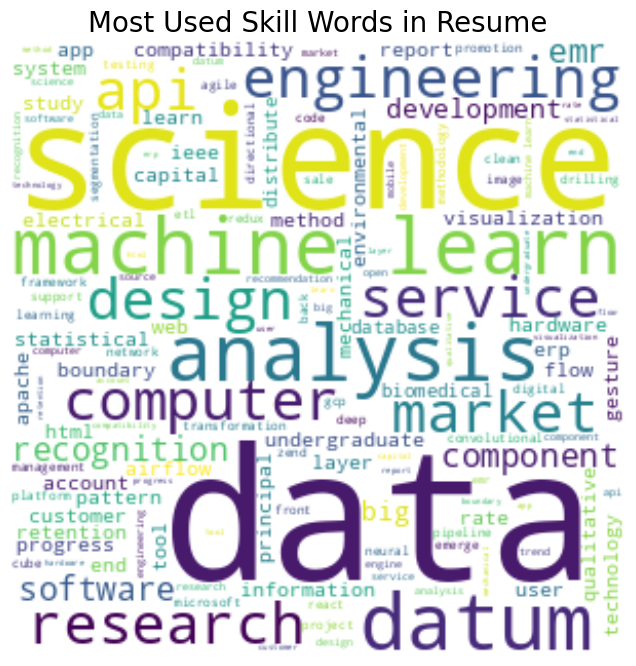

In [14]:
folder_path = "/content/drive/MyDrive/Data Set/Business Analytics Cv"


# To extract text from pdf files
extract_pdf_text(folder_path)


# To create a csv file from the extracted text
text_to_csv(folder_path)

# To load the csv file
file_path = 'text_files.csv'
df = load_csv(file_path)


# To preprocess the text in the csv file
clean = []
for i in range(df.shape[0]):
    review = re.sub(
                '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
                        " ",
                        df["text"].iloc[i],
                                        )
    review = review.lower()  # Corrected indentation
    review = review.split()  # Corrected indentation
    lm = WordNetLemmatizer()  # Corrected indentation

    review = [
                lm.lemmatize(word)
                for word in review
                if not word in set(stopwords.words('english'))
            ]
    review = ' '.join(review)
    clean.append(review)

df["Clean_Resume"] = clean # Corrected indentation

df['skills'] = df['Clean_Resume'].apply(extract_skills) # Corrected indentation
df.head()
create_wordcloud(df, "skills") # Corrected indentation

In [15]:
def rank_resumes(df, keywords, scores):
    scores_dict = dict(zip(keywords, scores))
    df["rank"] = 0

    for i in range(df.shape[0]):
        resume_skills = df["skills"].iloc[i].lower()  # Convert skills to lowercase
        print(f"Processing Resume {i+1}")
        print(f"Skills: {resume_skills}")
        for keyword in keywords:
            if any(keyword_part in resume_skills for keyword_part in keyword.split()):
                df.at[i, "rank"] += scores_dict[keyword]
                print(f"Keyword matched: {keyword}, Score added: {scores_dict[keyword]}")
                print(f"Total Rank for Resume {i+1}: {df['rank'].iloc[i]}\n")

    df = df.sort_values("rank", ascending=False)
    return df

In [16]:
# New function to analyze resume formatting and structure quality
def analyze_formatting_quality(text):
    """
    Analyzes the formatting and structure quality of a resume text.
    Returns a score based on criteria such as sections, bullets, and length.
    """
    formatting_score = 0 # Corrected indentation - This line should not be indented

    # 1. Check for common sections
    sections = ["education", "experience", "skills", "contact", "projects", "certifications"]
    section_count = sum(1 for section in sections if re.search(rf"\b{section}\b", text, re.IGNORECASE))
    if section_count >= 3:  # At least 3 main sections are present
        formatting_score += 1

    # 2. Check for bullets usage (e.g., using "-" or "*" or "•")
    if re.search(r"(\n\s*[-*•])", text):
        formatting_score += 1

    # 3. Check for resume length (word count)
    word_count = len(text.split())
    if 150 <= word_count <= 1000:  # Typical resume word count range
        formatting_score += 1

    # 4. Check for contact information (e.g., phone number, email)
    if re.search(r"\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b", text) or re.search(r"\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}", text):
        formatting_score += 1

    return formatting_score

In [17]:
# Integrate the function within the main data processing workflow
def rank_resumes(df, keywords, scores):
    scores_dict = dict(zip(keywords, scores))
    df["rank"] = 0  # Initialize rank column
    df["formatting_quality"] = 0  # Initialize formatting quality column

    for i in range(df.shape[0]):
        resume_text = df["Clean_Resume"].iloc[i]
        resume_skills = df["skills"].iloc[i]

        # Skill-based ranking
        for keyword in keywords:
            if any(keyword_part in resume_skills for keyword_part in keyword.split()):
                df.at[i, "rank"] += scores_dict[keyword]
                print(f"Keyword matched: {keyword}, Score added: {scores_dict[keyword]}")
                print(f"Total Rank for Resume {i+1}: {df['rank'].iloc[i]}\n")

        # Formatting quality analysis
        formatting_score = analyze_formatting_quality(resume_text)
        df.at[i, "formatting_quality"] = formatting_score
        print(f"Formatting Quality Score for Resume {i+1}: {formatting_score}\n")

    # Sort by rank and formatting quality
    df = df.sort_values(by=["rank", "formatting_quality"], ascending=[False, False])
    return df

In [18]:
keywords = ['business development','machine learn', 'time management']# key words to be searched in skills
scores = [2, 3, 1]# scores for the above skills in respective order
df = rank_resumes(df, keywords, scores)
df.to_csv('/content/drive/MyDrive/Data Set/ranked_resumesBA.csv', index=False)

Keyword matched: machine learn, Score added: 3
Total Rank for Resume 1: 3

Formatting Quality Score for Resume 1: 2

Keyword matched: machine learn, Score added: 3
Total Rank for Resume 2: 3

Formatting Quality Score for Resume 2: 0

Keyword matched: machine learn, Score added: 3
Total Rank for Resume 3: 3

Formatting Quality Score for Resume 3: 1

Keyword matched: business development, Score added: 2
Total Rank for Resume 4: 2

Keyword matched: machine learn, Score added: 3
Total Rank for Resume 4: 5

Formatting Quality Score for Resume 4: 2

Keyword matched: business development, Score added: 2
Total Rank for Resume 5: 2

Keyword matched: machine learn, Score added: 3
Total Rank for Resume 5: 5

Keyword matched: time management, Score added: 1
Total Rank for Resume 5: 6

Formatting Quality Score for Resume 5: 2

